In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='gray')
import matplotlib.animation
%matplotlib ipympl
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import cv2
from tqdm import tqdm
import random
from stardist import _draw_polygons
from stardist.models import StarDist2D
from csbdeep.utils import normalize
import skimage
from scipy.optimize import dual_annealing, minimize
from tifffile import imsave, imread
from tracking_utils import *
import trackpy as tp

In [2]:
#model_name = 'stardist_trained'          # stardist model trained for 50 epochs on simulated synthetic dataset
model_name = 'modified_2D_versatile_fluo' # stardist model trained for 150 epochs on simulated dataset starting from the pretrained 2D versatile fluo model
model = StarDist2D(None, name = model_name, basedir = './models/')
video_selection = '25b25r-1'#"49b1r"

if video_selection == "25b25r-1":
    xmin, ymin, xmax, ymax = 95, 30, 535, 470 
    merge_present = False   
elif video_selection == "25b25r-2":
    xmin, ymin, xmax, ymax = 82, 13, 410, 342 
    merge_present = False   
elif video_selection == "49b1r":
    xmin, ymin, xmax, ymax = 20, 50, 900, 930
    merge_present = True
    merge_frame = 32269


save_path       = f'./{video_selection}/{model_name}/'
source_path     = f'./data/{video_selection}.mp4'
system_name     = f'{video_selection} system'
nDrops = 50

video = cv2.VideoCapture(source_path)
video.set(cv2.CAP_PROP_POS_FRAMES, 0)
w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video.get(cv2.CAP_PROP_FPS))
n_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Video has {n_frames} frames with a resolution of {w}x{h} and a framerate of {fps} fps")

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.989263, nms_thresh=0.3.
Video has 540000 frames with a resolution of 640x480 and a framerate of 30 fps


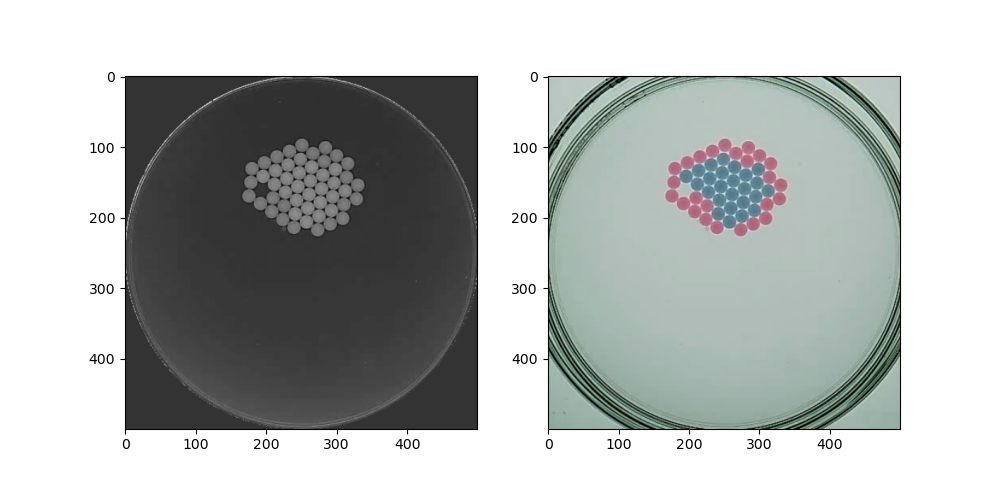

In [3]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 5))
ax.imshow(get_frame(video, n_frames -1, xmin, ymin, xmax, ymax, w, h, True))
ax1.imshow(get_frame(video, n_frames -1, xmin, ymin, xmax, ymax, w, h, False))
plt.show()

In [5]:
test_verb = False
detect_verb = False
link_verb = False
interp_verb = False

startFrame = 0
endFrame = n_frames - 1

In [ ]:
if test_verb: 
    n_samples = 1000
    test_detection(n_samples, n_frames, nDrops, video_selection, model, model_name, video, xmin, ymin, xmax, ymax, w, h, save_path)

In [ ]:
if detect_verb:
    print(f'Processing from {int(startFrame/fps)} s to {int(endFrame/fps)} s')
    sample_frames = np.arange(startFrame, endFrame, 1, dtype=int)
    raw_detection_df = detect_features(sample_frames, False, video_selection, model, model_name, video, xmin, ymin, xmax, ymax, w, h, save_path)
    
    n_feature_per_frame = raw_detection_df.groupby('frame').count().x.values
    fig, ax = plt.subplots(2, 2, figsize = (8, 4))
    ax[0, 0].plot(raw_detection_df.frame.unique(), n_feature_per_frame, '.')
    ax[0, 0].set(xlabel = 'Frame', ylabel = 'N of droplets', title = 'N of droplets per frame')
    ax[0, 1].plot(raw_detection_df.r, '.')
    ax[0, 1].set(xlabel = 'Feature index', ylabel = 'Radius [px]', title = 'Radius of features detected')
    ax[1, 0].scatter(raw_detection_df.r, raw_detection_df.eccentricity, s=0.1)
    ax[1, 0].set(xlabel = 'Radius [px]', ylabel='Eccentricity', title='R-eccentricity correlation')
    ax[1, 1].scatter(raw_detection_df.r, raw_detection_df.prob, s=0.1)
    ax[1, 1].set(xlabel = 'Radius [px]', ylabel='Probability', title='R-Probability correlation')
    plt.tight_layout()
    plt.savefig(save_path + f'raw_features_{model_name}_{startFrame}_{endFrame}.png', dpi = 500)
    plt.close()
else:
    raw_detection_df = pd.read_parquet(save_path + f'raw_detection_{video_selection}_modified_2D_versatile_fluo_{startFrame}_{endFrame}.parquet')
    sample_frames = raw_detection_df.frame.unique()

    n_feature_per_frame = raw_detection_df.groupby('frame').count().x.values
    fig, ax = plt.subplots(2, 2, figsize = (8, 4))
    ax[0, 0].plot(raw_detection_df.frame.unique(), n_feature_per_frame, '.')
    ax[0, 0].set(xlabel = 'Frame', ylabel = 'N of droplets', title = 'N of droplets per frame')
    ax[0, 1].plot(raw_detection_df.r, '.')
    ax[0, 1].set(xlabel = 'Feature index', ylabel = 'Radius [px]', title = 'Radius of features detected')
    ax[1, 0].scatter(raw_detection_df.r, raw_detection_df.eccentricity, s=0.1)
    ax[1, 0].set(xlabel = 'Radius [px]', ylabel='Eccentricity', title='R-eccentricity correlation')
    ax[1, 1].scatter(raw_detection_df.r, raw_detection_df.prob, s=0.1)
    ax[1, 1].set(xlabel = 'Radius [px]', ylabel='Probability', title='R-Probability correlation')
    plt.tight_layout()
    plt.savefig(save_path + f'raw_features_{model_name}_{startFrame}_{endFrame}.png', dpi = 500)
    plt.close()

In [ ]:
if merge_present:
    err_frames_pre_merge = np.where(raw_detection_df.loc[raw_detection_df.frame < merge_frame].groupby('frame').count().x.values != nDrops)[0]
    err_frames_post_merge = merge_frame + np.where(raw_detection_df.loc[raw_detection_df.frame >= merge_frame].groupby('frame').count().x.values != nDrops-1)[0] 
    print(f'Number of errors: {len(err_frames_pre_merge)} / {len(sample_frames[:merge_frame])} --> {len(err_frames_pre_merge)/len(sample_frames[:merge_frame])*100:.2f}%')
    print(f'Number of errors: {len(err_frames_post_merge)} / {len(sample_frames[merge_frame:])} --> {len(err_frames_post_merge)/len(sample_frames[merge_frame:])*100:.2f}%')
    condition = np.ediff1d(err_frames_pre_merge)
    condition[condition == 1] = True
    condition[condition != 1] = False
    if 1 in condition:
        max_n_of_consecutive_errs_pre_merge = max(np.diff(np.where(np.concatenate(([condition[0]], condition[:-1] != condition[1:], [True])))[0])[::2])
        print(f'Max number of consecutive errors pre merge: {max_n_of_consecutive_errs_pre_merge}')
    else:
        max_n_of_consecutive_errs_pre_merge = 0
        print(f'Max number of consecutive errors pre merge: 0')
    condition = np.ediff1d(err_frames_post_merge)
    condition[condition == 1] = True
    condition[condition != 1] = False
    if 1 in condition:
        max_n_of_consecutive_errs_post_merge = max(np.diff(np.where(np.concatenate(([condition[0]], condition[:-1] != condition[1:], [True])))[0])[::2])
        print(f'Max number of consecutive errors pre merge: {max_n_of_consecutive_errs_post_merge}')
    else:
        max_n_of_consecutive_errs_post_merge = 0
        print(f'Max number of consecutive errors pre merge: 0')
else:
    err_frames = np.where(raw_detection_df.groupby('frame').count().x.values != nDrops)[0]
    print(f'Number of errors: {len(err_frames)} / {len(sample_frames)} --> {len(err_frames)/len(sample_frames)*100:.2f}%')
    condition = np.ediff1d(err_frames)
    condition[condition == 1] = True
    condition[condition != 1] = False
    if 1 in condition:
        max_n_of_consecutive_errs = max(np.diff(np.where(np.concatenate(([condition[0]], condition[:-1] != condition[1:], [True])))[0])[::2])
        print(f'Max number of consecutive errors: {max_n_of_consecutive_errs}')
    else:
        max_n_of_consecutive_errs = 0
        print(f'Max number of consecutive errors: 0')

if merge_present: 
    traj_test = raw_detection_df.loc[raw_detection_df.frame.isin(np.append(err_frames_pre_merge, err_frames_post_merge))]
else: 
    traj_test = raw_detection_df.loc[raw_detection_df.frame.isin(err_frames)]
fig, ax = fig, ax = plt.subplots(1, 1, figsize=(10, 10))
def update_graph(frame):
    df = traj_test.loc[(traj_test.frame == frame), ["x", "y", "r"]]
    for i in range(len(df)):
        graph[i].center = (df.x.values[i], df.y.values[i])
        graph[i].radius = df.r.values[i]
    graph2.set_data(get_frame(video, frame, xmin, ymin, xmax, ymax, w, h, False))
    title.set_text(f'{system_name} Tracking -- t = {round(frame/fps, 1)} s')
    return graph

title = ax.set_title(f'{system_name} Tracking -- t = {0} s')
ax.set(xlabel = 'X [px]', ylabel = 'Y [px]')
df = traj_test.loc[(traj_test.frame == min(traj_test.frame.unique())), ["x", "y", "r"]]
graph = []
for i in range(len(df)):
    graph.append(ax.add_artist(plt.Circle((df.x.values[i], df.y.values[i]), df.r.values[i], color = 'red',\
                                           fill = False, alpha = 0.5, linewidth=1)))
graph2 = ax.imshow(get_frame(video, 0, xmin, ymin, xmax, ymax, w, h, False))
ani = matplotlib.animation.FuncAnimation(fig, update_graph, traj_test.frame.unique(), interval = 5, blit=False)
writer = matplotlib.animation.FFMpegWriter(fps = 30, metadata = dict(artist='Matteo Scandola'), extra_args=['-vcodec', 'libx264'])
ani.save(f'./{save_path}/tracking_video_errors.mp4', writer=writer, dpi = 200)
plt.close()

In [6]:
if link_verb:
    if merge_present:
        print('Linking trajectories...')
        cutoff = 100

        ## PRE MERGE
        t = tp.link_df(raw_detection_df.loc[raw_detection_df.frame < merge_frame], cutoff,\
                                 memory = max_n_of_consecutive_errs_pre_merge, link_strategy = 'hybrid', neighbor_strategy = 'KDTree', adaptive_stop = 1)
        t = t.sort_values(['frame', 'particle'])
        trajectories_pre_merge = tp.filter_stubs(t, 25)
        # CREATE COLOR COLUMN AND SAVE DF
        n = max(trajectories_pre_merge.particle)
        print(f'N of droplets pre merge: {n + 1}')
        random.seed(5)
        colors = ['#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]
        for i in range(max(trajectories_pre_merge.particle)+1-n):
            colors.append('#00FFFF')
        c = []
        for p in t.particle:
            c.append(colors[p])
        trajectories_pre_merge['color'] = c
        trajectories_pre_merge = trajectories_pre_merge.reset_index(drop=True)
        trajectories_pre_merge.to_parquet(save_path + f'raw_tracking_{video_selection}_modified_2D_versatile_fluo_pre_merge.parquet', index = False)

        ## POST MERGE
        t = tp.link_df(raw_detection_df.loc[raw_detection_df.frame >= merge_frame], cutoff,\
                                  memory = max_n_of_consecutive_errs_post_merge, link_strategy = 'hybrid', neighbor_strategy = 'KDTree', adaptive_stop = 1)
        t = t.sort_values(['frame', 'particle'])
        trajectories_post_merge = tp.filter_stubs(t, 25)
        # CREATE COLOR COLUMN AND SAVE DF
        n = max(trajectories_post_merge.particle)
        print(f'N of droplets post merge: {n + 1}')
        random.seed(5)
        colors = ['#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]
        for i in range(max(trajectories_post_merge.particle)+1-n):
            colors.append('#00FFFF')
        c = []
        for p in t.particle:
            c.append(colors[p])
        trajectories_post_merge['color'] = c
        trajectories_post_merge = trajectories_post_merge.reset_index(drop=True)
        trajectories_post_merge.to_parquet(save_path + f'raw_tracking_{video_selection}_modified_2D_versatile_fluo_post_merge.parquet', index = False)
    else:
        print('Linking trajectories...')
        cutoff = 100
        t = tp.link_df(raw_detection_df, cutoff, memory = max_n_of_consecutive_errs, link_strategy = 'hybrid', neighbor_strategy = 'KDTree', adaptive_stop = 1)
        #print(t)
        t = t.sort_values(['frame', 'particle'])
        trajectories = tp.filter_stubs(t, 25)
        # CREATE COLOR COLUMN AND SAVE DF
        n = max(trajectories.particle)
        print(f'N of droplets: {n + 1}')
        random.seed(5)
        colors = ['#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]
        for i in range(max(trajectories.particle)+1-n):
            colors.append('#00FFFF')
        c = []
        for p in t.particle:
            c.append(colors[p])
        trajectories['color'] = c
        trajectories = trajectories.reset_index(drop=True)
        trajectories.to_parquet(save_path + f'raw_tracking_{video_selection}_modified_2D_versatile_fluo_{startFrame}_{endFrame}.parquet', index = False)
else:
    if merge_present:
        print('Importing linked trajectories...')
        trajectories_pre_merge = pd.read_parquet(save_path + f'raw_tracking_{video_selection}_modified_2D_versatile_fluo_pre_merge.parquet')
        trajectories_post_merge = pd.read_parquet(save_path + f'raw_tracking_{video_selection}_modified_2D_versatile_fluo_post_merge.parquet')
    else:
        print('Importing linked trajectories...')
        trajectories = pd.read_parquet(save_path + f'raw_tracking_{video_selection}_modified_2D_versatile_fluo_{startFrame}_{endFrame}.parquet')

Importing linked trajectories...


In [ ]:
if interp_verb:
    if merge_present:
        print('Interpolating trajectories...')
        interp_trajectories_pre_merge = trajectories_pre_merge.groupby('particle').apply(interpolate_trajectory)
        interp_trajectories_pre_merge = interp_trajectories_pre_merge.reset_index(drop=True)
        interp_trajectories_pre_merge['particle'] = interp_trajectories_pre_merge['particle'].astype(int)
        interp_trajectories_pre_merge = interp_trajectories_pre_merge.sort_values(['frame', 'particle'])
        interp_trajectories_pre_merge.to_parquet(save_path + f'interpolated_tracking_{video_selection}_modified_2D_versatile_fluo_pre_merge.parquet', index=False)

        interp_trajectories_post_merge = trajectories_post_merge.groupby('particle').apply(interpolate_trajectory)
        interp_trajectories_post_merge = interp_trajectories_post_merge.reset_index(drop=True)
        interp_trajectories_post_merge['particle'] = interp_trajectories_post_merge['particle'].astype(int)
        interp_trajectories_post_merge = interp_trajectories_post_merge.sort_values(['frame', 'particle'])
        interp_trajectories_post_merge.to_parquet(save_path + f'interpolated_tracking_{video_selection}_modified_2D_versatile_fluo_post_merge.parquet', index=False)
    else:
        print('Interpolating trajectories...')
        interp_trajectories = trajectories.groupby('particle').apply(interpolate_trajectory)
        interp_trajectories = interp_trajectories.reset_index(drop=True)
        interp_trajectories['particle'] = interp_trajectories['particle'].astype(int)
        interp_trajectories = interp_trajectories.sort_values(['frame', 'particle'])
        interp_trajectories.to_parquet(save_path + f'interpolated_tracking_{video_selection}_modified_2D_versatile_fluo_{startFrame}_{endFrame}.parquet', index=False)
else:
    if merge_present:
        print('Importing interpolated trajectories...')
        interp_trajectories_pre_merge = pd.read_parquet(save_path + f'interpolated_tracking_{video_selection}_modified_2D_versatile_fluo_pre_merge.parquet')
        interp_trajectories_post_merge = pd.read_parquet(save_path + f'interpolated_tracking_{video_selection}_modified_2D_versatile_fluo_post_merge.parquet')
    else:
        print('Importing interpolated trajectories...')
        interp_trajectories = pd.read_parquet(save_path + f'interpolated_tracking_{video_selection}_modified_2D_versatile_fluo_{startFrame}_{endFrame}.parquet')

In [ ]:
n_feature_per_frame = interp_trajectories.groupby('frame').count().x.values
fig, ax = plt.subplots(2, 2, figsize = (8, 4))
ax[0, 0].plot(interp_trajectories.frame.unique(), n_feature_per_frame, '.')
ax[0, 0].set(xlabel = 'Frame', ylabel = 'N of droplets', title = 'N of droplets per frame')
ax[0, 1].plot(interp_trajectories.r, '.')
ax[0, 1].set(xlabel = 'Feature index', ylabel = 'Radius [px]', title = 'Radius of features detected')
ax[1, 0].scatter(interp_trajectories.r, interp_trajectories.eccentricity, s=0.1)
ax[1, 0].set(xlabel = 'Radius [px]', ylabel='Eccentricity', title='R-eccentricity correlation')
ax[1, 1].scatter(interp_trajectories.r, interp_trajectories.prob, s=0.1)
ax[1, 1].set(xlabel = 'Radius [px]', ylabel='Probability', title='R-Probability correlation')
plt.tight_layout()
plt.savefig(save_path + f'interp_features_{model_name}_{startFrame}_{endFrame}.png', dpi = 500)
plt.close()

In [ ]:
fig, ax = fig, ax = plt.subplots(1, 1, figsize=(10, 10))
def update_graph(frame):
    df = interp_trajectories.loc[(interp_trajectories.frame == frame), ["x", "y", "r", 'color']]
    for i in range(len(df)):
        graph[i].center = (df.x.values[i], df.y.values[i])
        graph[i].radius = df.r.values[i]
    graph2.set_data(get_frame(video, frame, xmin, ymin, xmax, ymax, w, h, False))
    title.set_text(f'{system_name} Tracking -- t = {round(frame/fps, 1)} s')
    return graph

title = ax.set_title(f'{system_name} Tracking -- t = {0} s')
ax.set(xlabel = 'X [px]', ylabel = 'Y [px]')
df = interp_trajectories.loc[(interp_trajectories.frame == min(interp_trajectories.frame.unique())), ["x", "y", "r", 'color']]
graph = []
for i in range(len(df)):
    graph.append(ax.add_artist(plt.Circle((df.x.values[i], df.y.values[i]), df.r.values[i], color = df.color.values[i],\
                                           fill = False)))
graph2 = ax.imshow(get_frame(video, 0, xmin, ymin, xmax, ymax, w, h, False))
ani = matplotlib.animation.FuncAnimation(fig, update_graph, interp_trajectories.frame.unique(), interval = 5, blit=False)
writer = matplotlib.animation.FFMpegWriter(fps = 30, metadata = dict(artist='Matteo Scandola'), extra_args=['-vcodec', 'libx264'])
ani.save(f'./{save_path}/tracking_video2.mp4', writer=writer, dpi = 200)
plt.close()

In [ ]:
test_frames = [12336,  12337,  12338,  12339,  12340,  12341, 12343]
missing_droplet_id = 43
df1 = trajectories.loc[(trajectories.frame < max(test_frames) + 15) & (trajectories.frame > min(test_frames) - 15) & (trajectories.particle == 43), ['x', 'y', 'frame', 'r', 'particle']]
df2 = interp_trajectories.loc[(interp_trajectories.frame < max(test_frames) + 15) & (interp_trajectories.frame > min(test_frames) - 15) & (interp_trajectories.particle == 43), ['x', 'y', 'frame', 'r', 'particle']]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(df1.x, df1.y, 'o', label = 'Raw', zorder = 20)
ax.plot(df2.x, df2.y, '--o', label = 'Interpolated', zorder = 10)
ax.set(xlabel = 'X [px]', ylabel = 'Y [px]', title = 'Example of interpolation on consecutive frame detection errors')
ax.legend()
plt.savefig(save_path + f'interp_example.png', dpi = 500)
plt.show()
